In [ ]:
!pip install -q -U keras-nlp keras datasets kagglehub keras_hub 
!pip install -q -U tensorflow-text
# Install tensorflow-cpu so tensorflow does not attempt to access the TPU.
!pip install -q -U tensorflow-cpu
!pip install -q -U wandb

In [2]:
import jax
jax.devices()

E0000 00:00:1735332070.778539      74 common_lib.cc:798] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: ===
learning/45eac/tfrc/runtime/common_lib.cc:479


E1227 20:41:10.834751243      74 oauth2_credentials.cc:238]            oauth_fetch: UNKNOWN:C-ares status is not ARES_SUCCESS qtype=A name=metadata.google.internal. is_balancer=0: Domain name not found {grpc_status:2, created_time:"2024-12-27T20:41:10.83473404+00:00"}


[TpuDevice(id=0, process_index=0, coords=(0,0,0), core_on_chip=0),
 TpuDevice(id=1, process_index=0, coords=(0,0,0), core_on_chip=1),
 TpuDevice(id=2, process_index=0, coords=(1,0,0), core_on_chip=0),
 TpuDevice(id=3, process_index=0, coords=(1,0,0), core_on_chip=1),
 TpuDevice(id=4, process_index=0, coords=(0,1,0), core_on_chip=0),
 TpuDevice(id=5, process_index=0, coords=(0,1,0), core_on_chip=1),
 TpuDevice(id=6, process_index=0, coords=(1,1,0), core_on_chip=0),
 TpuDevice(id=7, process_index=0, coords=(1,1,0), core_on_chip=1)]

In [3]:
import os
# from kaggle_secrets import UserSecretsClient
# from google.colab import userdata
#import getpass
os.environ["KAGGLE_USERNAME"] = "your-username"# or UserSecretsClient().get_secret(KAGGLE_USERNAME) or userdata.get(KAGGLE_USERNAME) or getpass.getpass("Enter your KAGGLE_USERNAME: ")
os.environ["KAGGLE_KEY"] = "kaggle-api-key" # or UserSecretsClient().get_secret(KAGGLE_KEY) or userdata.get(KAGGLE_KEY) or getpass.getpass("Enter your  KAGGLE_KEY: ")
os.environ["WANDB_API_KEY"] = "wand-api-key" # or UserSecretsClient().get_secret(WANDB_API_KEY) or userdata.get(WANDB_API_KEY) or getpass.getpass("Enter your WANDB_API_KEY: ")
os.environ["KERAS_BACKEND"] = "jax"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "1.00"

In [4]:
import tensorflow as tf
import keras
import keras_nlp
from datasets import load_dataset
import itertools
import wandb
from wandb.integration.keras import WandbMetricsLogger

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
data = load_dataset("allenai/c4", "ru", streaming=True)

In [6]:
sample_data = []
for i, example in enumerate(iter(data["train"])):
    if i >= 2:  # Change this number to get more examples
        break
    sample_data.append(example["text"])

print("Sample Russian Data:")
for i, text in enumerate(sample_data):
    print(f"Example {i + 1}:", text[:500])  # Print the first 500 characters to get a preview

Sample Russian Data:
Example 1: ✔👍🏿 Купить Seaweed Organic Mask в Новосибирске развод
Купить Seaweed Organic Mask в Новосибирске развод
Елена Малышева: "Пигментация лица в Новосибирске осталась в прошлом".
Перейти на сайт поставщика в Новосибирске
Seaweed Organic Mask маска из водорослей › ✔✔✔ в Новосибирске ✔✔✔
Опубликовано: 09.09.2017, 20:12 | Автор: Дарина Матвеева
Я тоже решила заказать.Когда глянула на статью, сразу поняла что Заказывала ЗДЕСЬ. Что этот тот же сайт. О котором и врач говорил. Вот только сроки до эффекта у 
Example 2: Наши отделения — Медицинский центр «САНА» — Медицинский центр в Алматы
Специализация Кардиолог, терапевт
Мустафина Айгуль Амирбековна
Савенко Галина Михайловна
Кардиолог, ревматолог, терапевт высшей категории
В медицинском центре «САНА» заботятся о здоровье Ваших детей с момента рождения.
Абдуллаева Гульбан Мухамеджановна
Врач педиатр, неонатолог высшей категории, кандидат медицинских наук
Бигазиева Зарина Койчибаевна
Исабаева Галия Кыдырбаевна
Сарбала

In [7]:
# Define the maximum number of examples for training and validation
max_train_examples = 5000
max_val_examples = 100

# Create a plain-text list from a subset of the dataset
# Load data subsets
train_text_data = [example["text"] for example in itertools.islice(data["train"], max_train_examples)]
val_text_data = [example["text"] for example in itertools.islice(data["validation"], max_val_examples)]

# Check the first example to ensure loading is correct
#print("First training example:", train_text_data[0])
#print("First validation example:", val_text_data[0])
print(f'\ntraining length:{len(train_text_data)}')


training length:5000


In [8]:
batch_size = 4

# Convert the lists of text data to TensorFlow datasets
train_data = tf.data.Dataset.from_tensor_slices(train_text_data)
val_data = tf.data.Dataset.from_tensor_slices(val_text_data)

# Preprocess each text sample
def preprocess_text(text):
    return tf.convert_to_tensor(text, dtype=tf.string)

# Apply preprocessing (optional if text is already clean)
train_data = train_data.map(preprocess_text)
val_data = val_data.map(preprocess_text)

# Shuffle and batch the training data
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size)
val_data = val_data.batch(batch_size)

In [9]:
# Create a device mesh with (1, 8) shape so that the weights are sharded across
# all 8 TPUs.
device_mesh = keras.distribution.DeviceMesh(
    (1, 8),
    ["batch", "model"],
    devices=keras.distribution.list_devices(),
)

model_dim = "model"

layout_map = keras.distribution.LayoutMap(device_mesh)

# Weights that match 'token_embedding/embeddings' will be sharded on 8 TPUs
layout_map["token_embedding/embeddings"] = (model_dim, None)
# Regex to match against the query, key and value matrices in attention layers
layout_map["decoder_block.*attention.*(query|key|value)/kernel"] = (model_dim, None, None)
layout_map["decoder_block.*attention_output/kernel"] = (model_dim, None, None)
layout_map["decoder_block.*ffw_gating.*/kernel"] = (None, model_dim)
layout_map["decoder_block.*ffw_linear/kernel"] = (model_dim, None)

model_parallel = keras.distribution.ModelParallel(
    layout_map=layout_map,
    batch_dim_name="batch",
)

keras.distribution.set_distribution(model_parallel)
model_id = "/kaggle/input/gemma2/keras/gemma2_9b_en/3" # change this if you want
gemma_lm = keras_nlp.models.GemmaCausalLM.from_preset(model_id)
gemma_lm.summary()

normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.


Preprocessor: "gemma_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma_tokenizer (GemmaTokenizer)                              │                      Vocab size: 256,000 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "gemma_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma_backbone                │ (None, None, 3584)        │   9,241,705,984 │ padding_mask[0][0],        │
│ (GemmaBackbone)               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 256000)      │     917,504,000 │ gemma_backbone[0][0]       │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 9,241,705,984 (34.43 GB)

 Trainable params: 9,241,705,984 (34.43 GB)

 Non-trainable params: 0 (0.00 B)

In [10]:
decoder_block_1 = gemma_lm.backbone.get_layer('decoder_block_1')
print(type(decoder_block_1))
for variable in decoder_block_1.weights:
  print(f'{variable.path:<48}  {str(variable.shape):<14}  {str(variable.value.sharding.spec)}')

<class 'keras_hub.src.models.gemma.gemma_decoder_block.GemmaDecoderBlock'>
decoder_block_1/pre_attention_norm/scale          (3584,)         PartitionSpec(None,)
decoder_block_1/post_attention_norm/scale         (3584,)         PartitionSpec(None,)
decoder_block_1/attention/query/kernel            (16, 3584, 256)  PartitionSpec('model', None, None)
decoder_block_1/attention/key/kernel              (8, 3584, 256)  PartitionSpec('model', None, None)
decoder_block_1/attention/value/kernel            (8, 3584, 256)  PartitionSpec('model', None, None)
decoder_block_1/attention/attention_output/kernel  (16, 256, 3584)  PartitionSpec('model', None, None)
decoder_block_1/pre_ffw_norm/scale                (3584,)         PartitionSpec(None,)
decoder_block_1/post_ffw_norm/scale               (3584,)         PartitionSpec(None,)
decoder_block_1/ffw_gating/kernel                 (3584, 14336)   PartitionSpec(None, 'model')
decoder_block_1/ffw_gating_2/kernel               (3584, 14336)   Partition

In [11]:
template = "Instruction:\n{instruction}\n\nResponse:\n{response}"

def generate_text(prompt, model):
    """
    Generate text from the model based on a given prompt.
    """
    sampler = keras_nlp.samplers.TopKSampler(k=5, seed=2)
    model.compile(sampler=sampler)
    output = model.generate(prompt, max_length=512)
    return output

In [12]:
# Sample prompt to check performance before and after fine-tuning
test_prompts = [
    "Привет! Как дела сегодня? Расскажи что-нибудь интересное, что ты недавно узнал.", # Greeting and request for recent information
    "Что ты знаешь об истории Ренессанса в Италии? Можешь объяснить его влияние на искусство и науку?", # Request for historical knowledge and cultural impact
    "Напиши небольшое стихотворение на русском языке об осеннем пейзаже.", # Request for poetic creativity
    "Объясни простыми словами, как работает искусственный интеллект и каковы его наиболее распространенные применения в России.", # Request for technical explanation and geographical context
    "Если кто-то скажет: 'За двумя зайцами погонишься, ни одного не поймаешь', что это будет значить? В какой ситуации можно использовать это выражение?", # Request for interpretation of an idiomatic expression
]

for prompt in test_prompts:
    print(f"\n--- Model Output Before Fine-Tuning for prompt: {prompt} ---")
    print(generate_text(template.format(instruction=prompt, response=""), gemma_lm))
    print("\n")


--- Model Output Before Fine-Tuning for prompt: Привет! Как дела сегодня? Расскажи что-нибудь интересное, что ты недавно узнал. ---


Instruction:
Привет! Как дела сегодня? Расскажи что-нибудь интересное, что ты недавно узнал.

Response:
Hello! How are you doing today? I recently learned that the word "cat" is derived from the Old English word "catta." It's fascinating to see how language evolves over time and how certain words come to be used in different ways. I find it interesting to explore the origins of words and how they've been shaped by different cultures and languages. It's also interesting to think about the ways in which our language can reflect our own unique personalities and experiences.



--- Model Output Before Fine-Tuning for prompt: Что ты знаешь об истории Ренессанса в Италии? Можешь объяснить его влияние на искусство и науку? ---


Instruction:
Что ты знаешь об истории Ренессанса в Италии? Можешь объяснить его влияние на искусство и науку?

Response:
Rinascimento in Italia, in art and science.

The word “Rinascimento” means “Renaissance” in Italian. It’s a historical movement of the 14th to 17th centuries that was characterized by a revival of art and literature. The Renaissance in Italy was the beginning of modern art. It was a period of great creativity and invention. The Renaissance in Italy is a time period that lasted from the 1400's to the 1600's. It is a time period that was characterized by a revival of art and literature.

It is important to note that the Renaissance in Italy was not only about art and literature, but also science, philosophy, religion and politics. The Renaissance in Italy was a period of great change in the world. It was a time of great discovery and invention.

The Renaissance was a time of discovery and invention. It is also a time of great art and literature, science, philosophy and

Instruction:
Напиши небольшое стихотворение на русском языке об осеннем пейзаже.

Response:
На осенний пейзаж я смотрю
И вижу, как меняю он цвет.
Листья желтые, красные кружат, 
В воздухе пахнет осенью спелым. 
На небе тучи, ветер дует в лицо,
Но я все равно люблю эту осень.



--- Model Output Before Fine-Tuning for prompt: Объясни простыми словами, как работает искусственный интеллект и каковы его наиболее распространенные применения в России. ---


Instruction:
Объясни простыми словами, как работает искусственный интеллект и каковы его наиболее распространенные применения в России.

Response:
Арtificial intelligence (AI) is a branch of computer science that aims to create systems that can perform tasks that typically require human intelligence, such as visual and auditory perception, decision-making, problem-solving, and learning. AI systems can be broadly classified into two categories: narrow AI or weak AI, which is limited to a specific task or set of tasks, and general AI or strong AI, which is able to perform any cognitive task that a human being can perform.

One of the most common applications of AI in Russia is in the field of finance. For example, many Russian banks use AI algorithms to analyze financial data and detect fraud. AI systems can also be used to provide personalized recommendations for investments, based on an individual’s financial goals and risk tolerance.

Another area where AI is widely used in Russia is 

Instruction:
Если кто-то скажет: 'За двумя зайцами погонишься, ни одного не поймаешь', что это будет значить? В какой ситуации можно использовать это выражение?

Response:
За двумя зайцами погонишься, ни одного не поймаешь – не следует браться за два дела одновременно, так как это приведет к некачественному выполнению обеих заданий. Это выражение используется в ситуациях, когда человек не хочет выполнять какое-то из заданий.




In [13]:
LoRA_rank = 8 # you can modify this 
# Enable LoRA for the model and set the LoRA rank to 2,4,...
gemma_lm.backbone.enable_lora(rank=LoRA_rank)
gemma_lm.summary()

Preprocessor: "gemma_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma_tokenizer (GemmaTokenizer)                              │                      Vocab size: 256,000 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "gemma_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma_backbone                │ (None, None, 3584)        │   9,270,779,392 │ padding_mask[0][0],        │
│ (GemmaBackbone)               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 256000)      │     917,504,000 │ gemma_backbone[0][0]       │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 9,270,779,392 (34.54 GB)

 Trainable params: 29,073,408 (110.91 MB)

 Non-trainable params: 9,241,705,984 (34.43 GB)

In [14]:
gemma_lm.preprocessor.sequence_length = 512
# Use AdamW (a common optimizer for transformer models).
optimizer = keras.optimizers.AdamW(
    learning_rate=5e-5,
    weight_decay=0.02,
)
# Exclude layernorm and bias terms from decay.
optimizer.exclude_from_weight_decay(var_names=["bias", "scale"])

gemma_lm.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=optimizer,
    weighted_metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

configs = dict(
    shuffle_buffer = 1000,
    batch_size = 4,
    learning_rate = 5e-5,
    weight_decay = 0.02,
    sequence_length = 512,
    epochs = 20,
)

wandb.init(project = "fine-tuning-gemma2_9b_ru",
    config=configs
)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


wandb: Currently logged in as: this-is-the-way-2005 (this-is-the-way-2005-independent). Use `wandb login --relogin` to force relogin


wandb: Tracking run with wandb version 0.19.1


wandb: Run data is saved locally in /kaggle/working/wandb/run-20241227_204831-1m0zu4lc
wandb: Run `wandb offline` to turn off syncing.


wandb: Syncing run zany-microwave-1


wandb: ⭐️ View project at https://wandb.ai/this-is-the-way-2005-independent/fine-tuning-gemma2_9b_ru


wandb: 🚀 View run at https://wandb.ai/this-is-the-way-2005-independent/fine-tuning-gemma2_9b_ru/runs/1m0zu4lc


In [ ]:
# Fit the model
history = gemma_lm.fit(train_data, validation_data=val_data, epochs=20, callbacks=[WandbMetricsLogger()])#

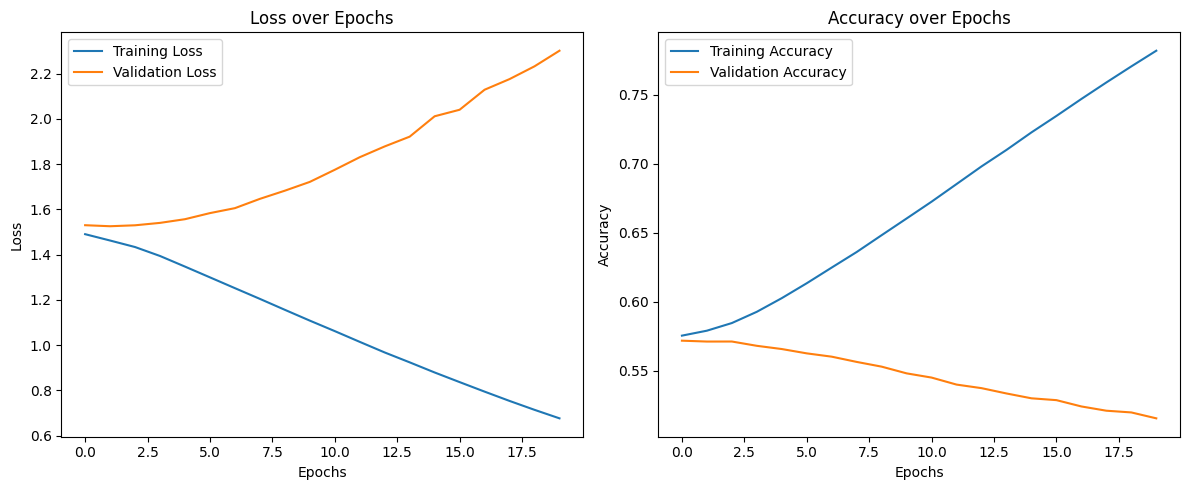

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Plotting Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['sparse_categorical_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [17]:
test_prompts = [
    "Привет! Как дела сегодня? Расскажи что-нибудь интересное, что ты недавно узнал.", # Greeting and request for recent information
    "Что ты знаешь об истории Ренессанса в Италии? Можешь объяснить его влияние на искусство и науку?", # Request for historical knowledge and cultural impact
    "Напиши небольшое стихотворение на русском языке об осеннем пейзаже.", # Request for poetic creativity
    "Объясни простыми словами, как работает искусственный интеллект и каковы его наиболее распространенные применения в России.", # Request for technical explanation and geographical context
    "Если кто-то скажет: 'За двумя зайцами погонишься, ни одного не поймаешь', что это будет значить? В какой ситуации можно использовать это выражение?", # Request for interpretation of an idiomatic expression
]

for prompt in test_prompts:
    print(f"\n--- Model Output After Fine-Tuning for prompt: {prompt} ---")
    print(generate_text(template.format(instruction=prompt, response=""), gemma_lm))
    print("\n")


--- Model Output After Fine-Tuning for prompt: Привет! Как дела сегодня? Расскажи что-нибудь интересное, что ты недавно узнал. ---


Instruction:
Привет! Как дела сегодня? Расскажи что-нибудь интересное, что ты недавно узнал.

Response:
Привет! Как дела? Я узнал, что некоторые люди могут слышать кровь, бурлящую в собственных венах. Это называется аускултация вен.
Привет! Как дела? Я узнал, что в 1974 году была выведена курица по кличке Мэнни Валлибо, которая умерла весом 89 фунтов 10 унций. Это было живое создание с самым ранним концом.
Привет! Как дела? Я узнал, что у пиявки 32 глаза, расположенные в пучке на каждом из своих 33 пар czułków.
Привет! Как дела? Я узнал, что некоторые ученые считают, что у некоторых людей есть шестой чувств. Некоторые люди могут чувствовать изменения погоды на изменение давления в окружающей среде.
Привет! Как дела? Я узнал, что в некоторых странах мира некоторые люди используют свои языки вместо мыла в качестве мыла.
Привет! Как дела? Некоторые люди используют свои ноги вместо рук.
Привет! Как дела? Некоторые люди считают, что у некоторых людей есть хвост вместо ног.
Привет! Как дела?





--- Model Output After Fine-Tuning for prompt: Что ты знаешь об истории Ренессанса в Италии? Можешь объяснить его влияние на искусство и науку? ---


Instruction:
Что ты знаешь об истории Ренессанса в Италии? Можешь объяснить его влияние на искусство и науку?

Response:
Ренессанс – это период времени в истории человечества, последовавший после «темных» Средневековья. Этот термин в переводе с латыни означает «возрождение». Название отражает суть происходивших переворотов в духовном и материальном развитии общества: художественное творчество, наука и экономика переживали свое возрождение. Это было обусловлено открытием огромного количества памятников древнегреко-римской культуры, что послужило началом нового интереса к ней. Ренессанс способствовал развитию и усовершенствованию науки. Например, появилось много новых инструментов для точных измерений, например, астрономических.
Также можно выделить влияние эпохи Возрождения на искусство. В то время появилось огромное количество шедевров живописи, скульптуры и архитектуры, авторами которых являлись выдающиеся личности эпохи. Искусство стремилось к правдивому отображению окружающего мира.


--- Model Output After Fine-Tuning for prompt: Напиши небольшое стихотворение на русском языке об осеннем пейзаже. ---

Instruction:
Напиши небольшое стихотворение на русском языке об осеннем пейзаже.

Response:
В город осенний заглянула,
В желтом пальто красотка.
Листва поскрипывает,
С дерева срываются крошки.
Голубой небосклон
И бархатный парк.
И листья, как листья,
Красятся, желтеют.
И солнце, как и обещало,
С утра нас порадовало.
Птицы к себе в теплые края
Уже в полет собрались.
Осень в окнах золотом засияла.
На деревьях листочки разноцветные качаются.
На небосклон голую
Прикоснулась лазурь.
И птицы к себе в теплые
Уже в полет собрались.
http://www.artofpoetry.ru/poem.php?t=1&lang=rus&id=116492





--- Model Output After Fine-Tuning for prompt: Объясни простыми словами, как работает искусственный интеллект и каковы его наиболее распространенные применения в России. ---


Instruction:
Объясни простыми словами, как работает искусственный интеллект и каковы его наиболее распространенные применения в России.

Response:
Ответ на вопрос «Что такое искусственный интеллект?» зависит от того, кого вы спрашиваете. Для тех, кто не слышал о ней, может сказать много, но ничего не даст. Вместо этого попробуйте думать о том, что искусственный интеллект. Искусственный интеллект — это отрасль, которая фокусируется на разработке «интеллектуальных» систем, таких как роботы и интеллектуальные компьютерные программы, которые могут действовать как люди.
На практике это означает, что эти программы должны иметь несколько ключевых возможностей:
Наблюдать и анализировать окружающий мир, воспринимая его через различные органы чувств, такие как камеры и микрофоны.
Использовать знания о мире для принятия решений в данный момент. Это называется инFERENCE.
Л earning по мере прохождения новых ситуаций.
Должны ли они достичь человеческого уровня в каждой из этих способностей? Нет, они





--- Model Output After Fine-Tuning for prompt: Если кто-то скажет: 'За двумя зайцами погонишься, ни одного не поймаешь', что это будет значить? В какой ситуации можно использовать это выражение? ---


Instruction:
Если кто-то скажет: 'За двумя зайцами погонишься, ни одного не поймаешь', что это будет значить? В какой ситуации можно использовать это выражение?

Response:
Кто ответит первым - получишь задание. Не факт, что я его выполню. Но я попробую.
Это значит что, если человек на что-то обращает внимание в ущерб чему-то другому, то он успеет сделать только первое, на что обращал внимание.
Это выражение относится к тому случаю, когда человек на что-то обращает внимание, но в случае если он на что-то ещё обратит, то не сможет добиться того, на что в первый раз обращал.
Это можно сказать в том случае, когда человек делает не то, что тебе сказал и ты ему хочешь объяснить, что если он будет работать как надо, то у него все получится.
Мария ответила быстрее всех, поэтому я её вопрос задам.
Я бы объяснила с помощью примера. Например, зайцы бегают по полю. Одному охотнику нужно с помощью ружья сбить зайца. Он нацеливается на первого зайца, но пока он стреляет, второй зайчик убегает. Это з

In [18]:
tmp_model_dir = "/kaggle/tmp/gemma2_9b_ru"  # Use /kaggle/tmp
preset_dir = "gemma2_9b_ru"
os.makedirs(tmp_model_dir, exist_ok=True)
gemma_lm.save_to_preset(tmp_model_dir)

print(f"Model saved to: {tmp_model_dir}")

Model saved to: /kaggle/tmp/gemma2_9b_ru

In [ ]:
import kagglehub
import keras_hub
if "KAGGLE_USERNAME" not in os.environ or "KAGGLE_KEY" not in os.environ:
    kagglehub.login()

model_version = 1
kaggle_username = kagglehub.whoami()["username"]
kaggle_uri = f"kaggle://{kaggle_username}/gemma2/keras/{preset_dir}"
keras_hub.upload_preset(kaggle_uri, tmp_model_dir)
print("Done!")